# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/index.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.1.2-

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

### Initialization ###
Starting Spark session:

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [ ]:
import urllib.request

In [ ]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7fa56a7046d0>)

Create a first RDD

In [ ]:
lines = sc.textFile("apache_logs")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas
import ipinfo

In [ ]:
# Zadanie 1.
safari_count = lines.filter(lambda x: 'Safari' in x and 'Chrome' not in x).count()
chrome_count = lines.filter(lambda x: 'Chrome' in x).count()
firefox_count = lines.filter(lambda x: 'Firefox' in x).count()
results = [safari_count,chrome_count,firefox_count]
print(results)
print(lines.count(),sum(results))

[764, 3172, 2778]
10000 6714


In [ ]:
lines.filter(lambda x: not(('Safari' in x and 'Chrome' not in x) or ('Chrome' in x) or ('Firefox' in x))).take(4)

['50.16.19.13 - - [17/May/2015:10:05:10 +0000] "GET /blog/tags/puppet?flav=rss20 HTTP/1.1" 200 14872 "http://www.semicomplete.com/blog/tags/puppet?flav=rss20" "Tiny Tiny RSS/1.11 (http://tt-rss.org/)"',
 '66.249.73.185 - - [17/May/2015:10:05:37 +0000] "GET / HTTP/1.1" 200 37932 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"',
 '46.105.14.53 - - [17/May/2015:10:05:03 +0000] "GET /blog/tags/puppet?flav=rss20 HTTP/1.1" 200 14872 "-" "UniversalFeedParser/4.2-pre-314-svn +http://feedparser.org/"',
 '123.125.71.35 - - [17/May/2015:10:05:46 +0000] "GET /blog/tags/release HTTP/1.1" 200 40693 "-" "Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html)"']

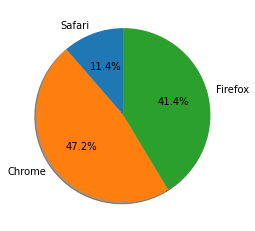

In [ ]:
plt.pie(results,labels=["Safari","Chrome","Firefox"],autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [ ]:
# Zadanie 2.
hour_regex = r"(?:/[0-9]+:)([0-9]+)(?::[0-9]+:[0-9]+)"
code_regex = r"\"(?:OPTIONS|HEAD|GET|POST).*\" (\d{3})"

hour_code = lines.map(lambda x: 
          (int(re.findall(hour_regex,x)[0]),int(re.findall(code_regex,x)[0]))
          ).countByValue()

hour_code_to_vis = []
for i in hour_code:
  hour_code_to_vis.append([i[0],i[1],hour_code[i]])

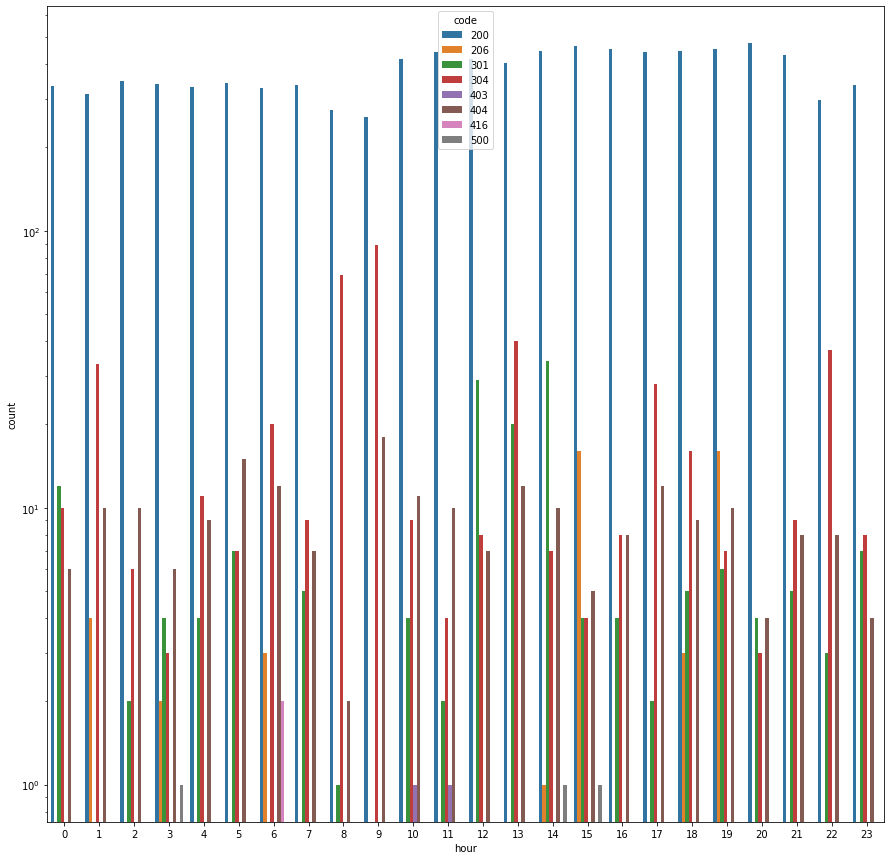

In [ ]:

df = pd.DataFrame(hour_code_to_vis)
df.columns = ['hour','code','count']
plt.figure(figsize=[15, 15])
sns.barplot(data=df, x='hour', y='count', hue='code')
plt.yscale('log')

In [ ]:
# Zadanie 3.
content_regex = r"\"GET /\S+\.([a-zA-Z]+) "
content_stats = lines.filter(lambda x: "GET" in x).map(lambda x: str(re.findall(content_regex,x))[2:-2]).filter(lambda x: len(x)).countByValue()

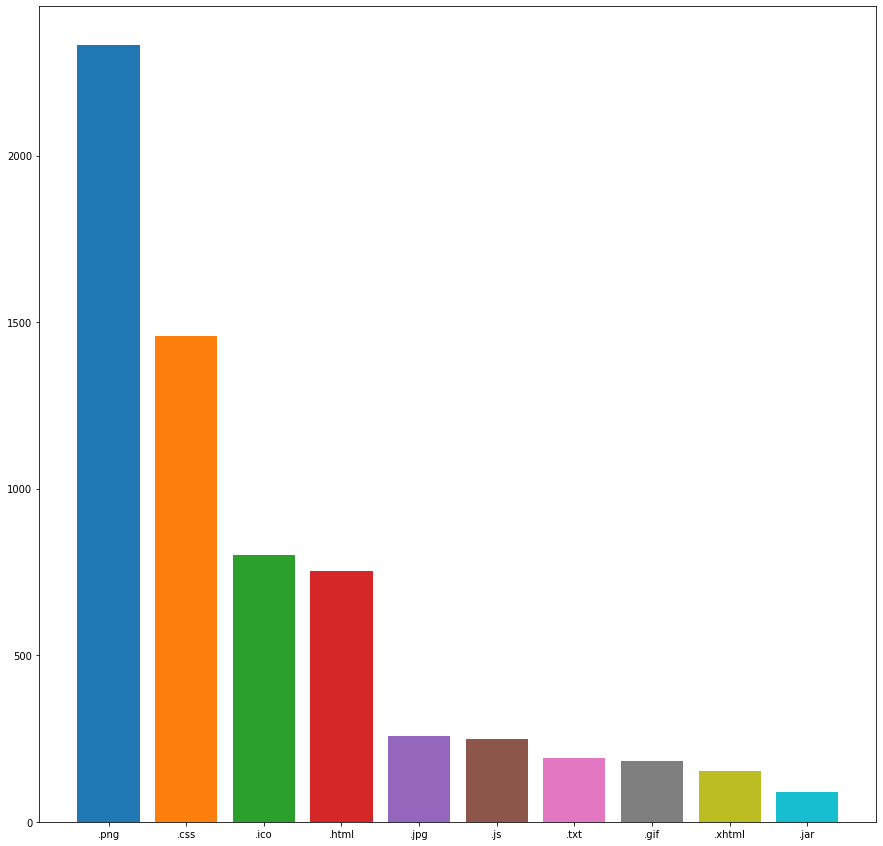

In [ ]:
fig = plt.figure()
fig.set_size_inches(15,15)
for _,i in zip(range(10),dict(sorted(content_stats.items(), key=lambda item: -item[1]))):
  plt.bar('.'+i,content_stats[i])
plt.show()

In [ ]:
# Zadanie 4

regex_ip = "[(\d\.)]+"

ips = lines.\
    map(lambda log: re.match(regex_ip, log).group(0)).\
    distinct().\
    collect()



In [ ]:
access_token = "c22157m4buhf16"
ipinfo_handler = ipinfo.getHandler(access_token=access_token)

ip_response = ipinfo_handler.getBatchDetails(ips)
locations = [
    details["loc"].split(",") 
    for details in ip_response.values()
]

locations = pd.DataFrame([(float(lat), float(long)) for lat, long in locations])

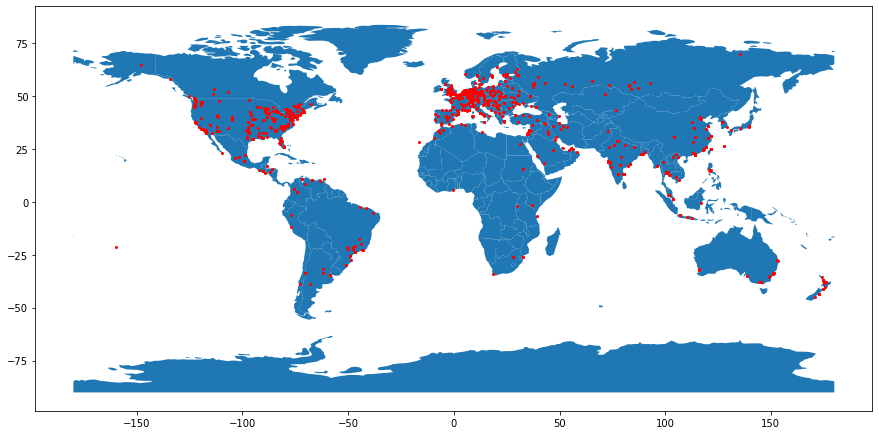

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,15)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax)
plt.scatter(locations[1],locations[0],c='red',s=4)
plt.show()

In [ ]:
# Zadanie 5
# Można wziąć wyniki z zadania 1. - liczbę wyników, które nie pasowały do żadnej przeglądarki - użytkownicy raczej korzystają
# z przeglądarek. Wyniki są bardzo wysokie, możliwe, że część komunikacji użytkowników wlicza się w obliczoną statystykę
lines.filter(lambda x: not(('Safari' in x and 'Chrome' not in x) or ('Chrome' in x) or ('Firefox' in x))).count()/lines.count()

0.3286

In [ ]:
# Można także poszukać nazwy botów w logach, jeżeli takie podają
print("Minimum: ",lines.filter(lambda x: 'Googlebot' in x or 'archive.org_bot' in x or 'Sogou' in x).count()/lines.count())
print("Maksimum: ",lines.filter(lambda x: 'bot' in x or "Bot" in x).count()/lines.count())

Minimum:  0.0732
Maksimum:  0.1313
